# Round 47

**TODO**:
* Compare t-test and KS-test
* Feature correlations
* t-SNE
* ...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Let's start by loading the data for this round using a few helpers from the package in this repository.

In [2]:
from numerai import Round

r47 = Round(47)
train = r47.training_set()
test = r47.test_set()

## Train/test sets comparison

### PCA plot

Numer.ai data points have a lot of features, but it may be interesting to plot a projection of all the points in training and test set on two dimensions. One way to do it is a Principal Component Analysis.

The numerai package in this repository provides a plot_PCA() method which computes the PCA and produces a pair plot of the training and tournament datasets:

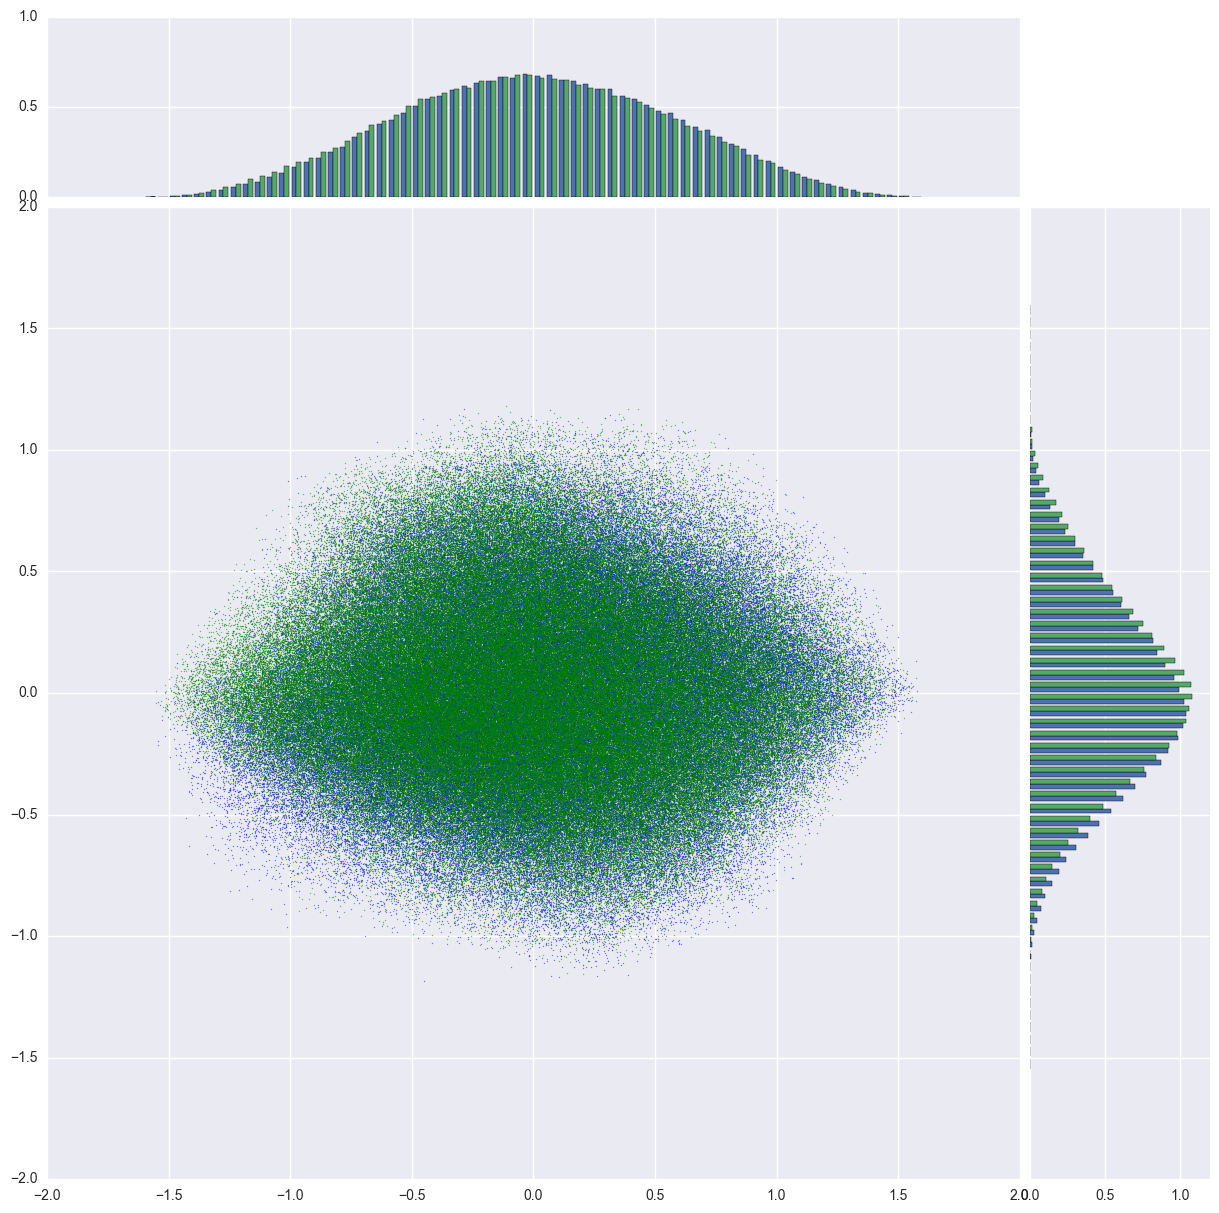

In [3]:
from numerai import plot_PCA

plot_PCA(train.drop('target',axis=1), test.drop('t_id',axis=1), 'is_test', 'fig', show=True)

### Training points by probability of appearing in test set

We can sort data points from the training set on the probability that they belong to the training set, as computed by a classifier trained to recognize train from test. This approach is detailed by Zygmunt Z. in two articles about adversarial validation on his blog FastML : http://fastml.com/adversarial-validation-part-one/, http://fastml.com/adversarial-validation-part-two/

There's one question I didn't answer: **what is the impact of the choice of classifier and its parameters on everything that follows?**

In [4]:
if not r47.has_sorted_training_set():
    r47.sort_training_set(classifier='LR')  # classifier is by default a standard sklearn.RandomForestClassifier

loading...
cross-validating...
# fold 1, Wed Mar 15 23:44:06 2017
# AUC: 72.56%

# fold 2, Wed Mar 15 23:44:14 2017
# AUC: 72.12%

# fold 3, Wed Mar 15 23:44:23 2017
# AUC: 72.49%

# fold 4, Wed Mar 15 23:44:31 2017
# AUC: 72.93%

# fold 5, Wed Mar 15 23:44:40 2017
# AUC: 72.47%



In [5]:
train_sorted = r47.sorted_training_set()

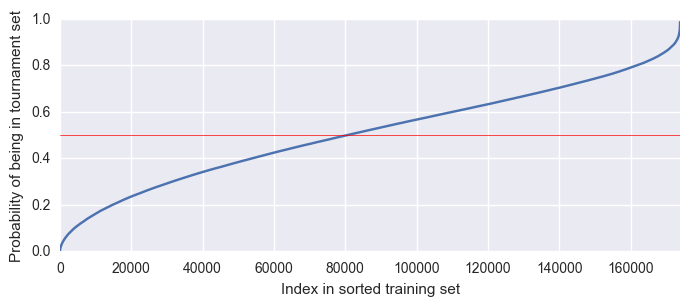

In [6]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
train_sorted.p.plot(ax=ax)
ax.axhline(y=0.5,color='r',lw=0.5)
ax.set_ylim(bottom=0, top=1)
ax.set_xlabel('Index in sorted training set')
ax.set_ylabel('Probability of being in tournament set')

### Kolmogorov-Smirnov feature similarity

According to Wikipedia, the Kolmogorov–Smirnov statistic can quantify a distance between the empirical distribution functions of two samples.

One could also say that the Kolmogorov-Smirnov can find much more general kinds of difference in distribution than the t-test can.

The kolmogorov_smirnov() method of this repository returns a pandas dataframe containing for each feature the Kolmogorov-Smirnov distance between training and test set along with the associated p-value.

In [7]:
from numerai import kolmogorov_smirnov

dfks = kolmogorov_smirnov(train.drop('target', axis=1), test)

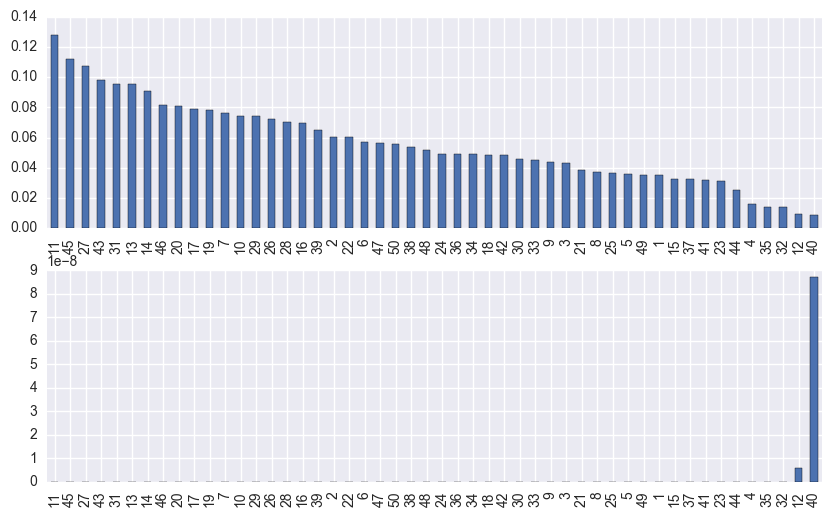

In [8]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
dfks.sort('KS',ascending=False)['KS'].plot(kind='bar',ax=ax1)
ax2 = fig.add_subplot(212)
dfks.sort('KS',ascending=False)['KS_p'].plot(kind='bar',ax=ax2)

As noted in the scipy documentation for ks_2samp, if the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

#### What if we drop an increasing number of data points in training set, starting from least similar to tournament set?

Looking at the training set, we may be tempted to drop points that are not similar enough to the tournament set in order to train our models on a more tournament-like training set.

One way to look at this would be to set a probability threshold on the sorted training set and then cut. Another way to look is to test many cut sizes on the sorted training set and compute the K-S for each resulting training set.

In [9]:
from scipy import stats

dropped_sizes = range(5000, len(train_sorted), 5000)

mean_ks = []
for sz in dropped_sizes:
    
    drop_train = train_sorted.iloc[sz:]

    ks = []
    for c in drop_train.drop(['target','p'],axis=1).columns:
        res = stats.ks_2samp(drop_train[c], test[c])
        ks.append(res.statistic)
    dfks_ = pd.DataFrame(index=range(1,51))
    dfks_['ks'] = ks
    #print '{}: m = {}'.format(sz, dfks_.ks.mean())
    mean_ks.append(dfks_.ks.mean())

dfmks = pd.DataFrame(index=dropped_sizes)
dfmks['m'] = mean_ks

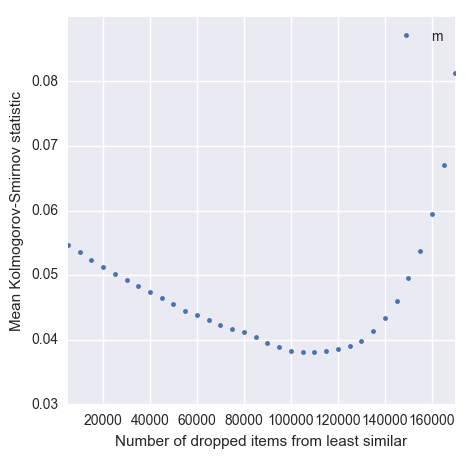

In [10]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
dfmks.plot(style='.',ax=ax)
ax.set_xlabel('Number of dropped items from least similar')
ax.set_ylabel('Mean Kolmogorov-Smirnov statistic')

In [11]:
dfmks.idxmin()

m    105000
dtype: int64

We get a cut size on the training set which minimizes the average K-S between training and tournament set. But it considers the whole tournament set: we don't know which subset is actually used for the private leaderboard and if it has the same distribution as the whole tournament set.

## Feature ranking

Next paragraphs are inspired by the articles on feature selection written by Ando Saabas on his blog *Dive into data*: http://blog.datadive.net/category/feature-selection/

### Univariate selection

In [12]:
from numerai import pearson

dfp = pearson(train.drop('target', axis=1), train.target)

(0.0, 1)

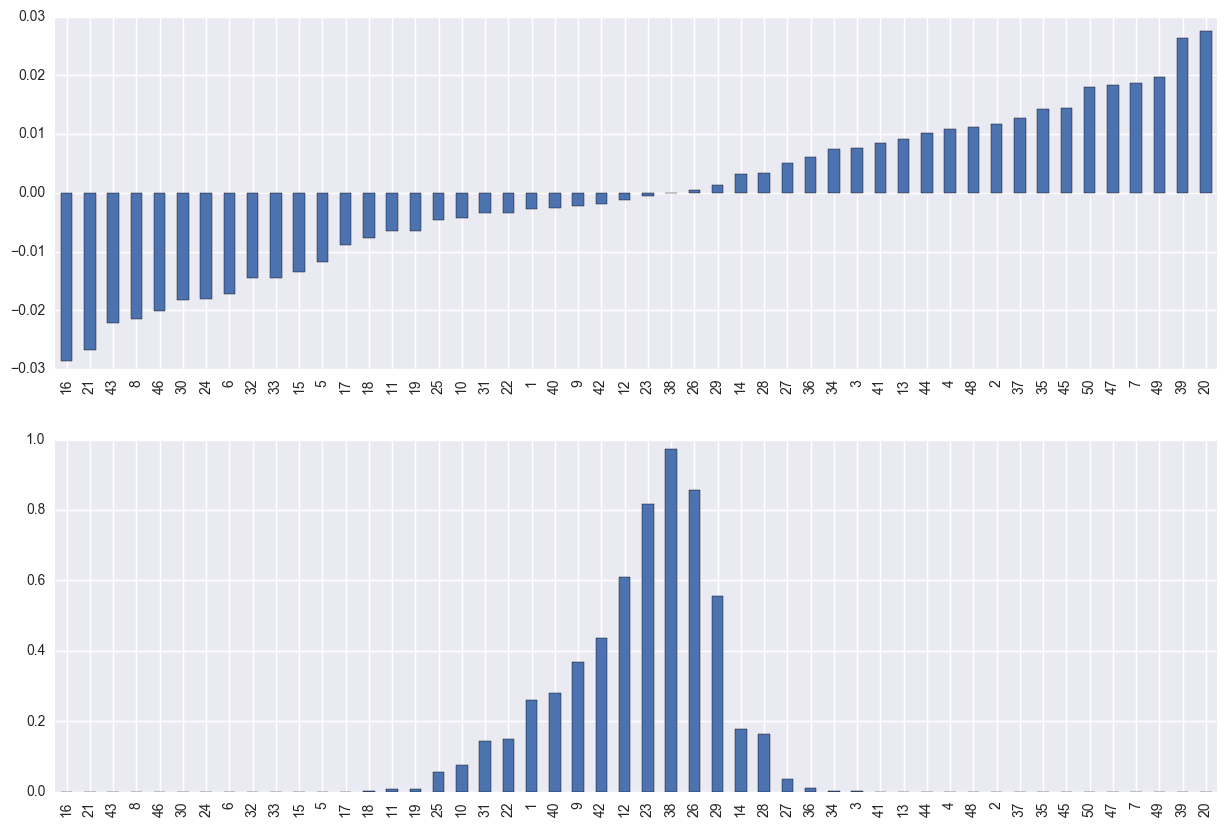

In [13]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
dfp.sort('pearson')['pearson'].plot(kind='bar',ax=ax1)
ax2 = fig.add_subplot(212)
dfp.sort('pearson')['pearson_p'].plot(kind='bar',ax=ax2)
#ax2.set_yscale("log")
ax2.set_ylim(top=1)

### Feature ranking by logistic regression with $L^2$ penalty

But... what is the impact of the choice of parameters for the logistic regression on this ranking?

In [14]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train.drop('target', axis=1),
                                                    train.target,
                                                    test_size=0.2,
                                                    random_state=0)

In [15]:
from sklearn.linear_model import LogisticRegression as LR

m_lr_l2 = LR(C=0.5,
             fit_intercept=False,
             max_iter=100,
             penalty='l2',
             tol=1e-4,
             solver='sag',
             n_jobs=6)
m_lr_l2.fit(x_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=6,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
df = pd.DataFrame(m_lr_l2.coef_[0],index=range(1,len(train.columns)))
df.columns = ['LR_L2_coefs']

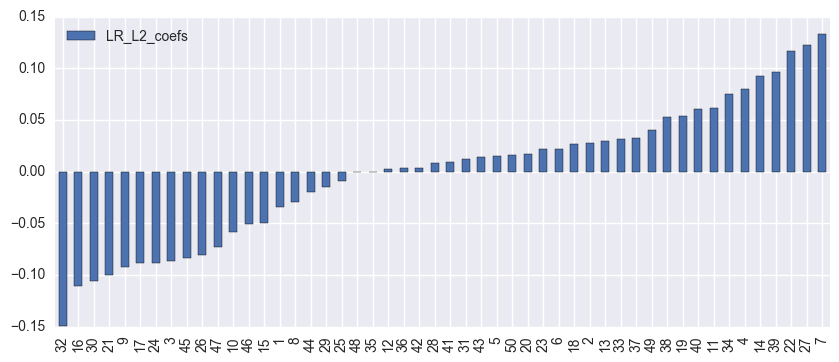

In [17]:
fig = plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
df.sort('LR_L2_coefs').plot(kind='bar',ax=ax)

### Feature ranking by random forests

#### Mean decrease impurity

In [18]:
x_train, x_test, y_train, y_test = train_test_split(train.drop('target', axis=1),
                                                    train.target,
                                                    test_size=0.2,
                                                    random_state=0)

In [19]:
from sklearn.ensemble import RandomForestClassifier as RF

m_rf = RF(n_jobs=6)

In [20]:
m_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=6,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
df_rf_mdi = pd.DataFrame(m_rf.feature_importances_,index=range(1,len(train.columns)))
df_rf_mdi.columns = ['RF_mdi']

(0.018, 0.022)

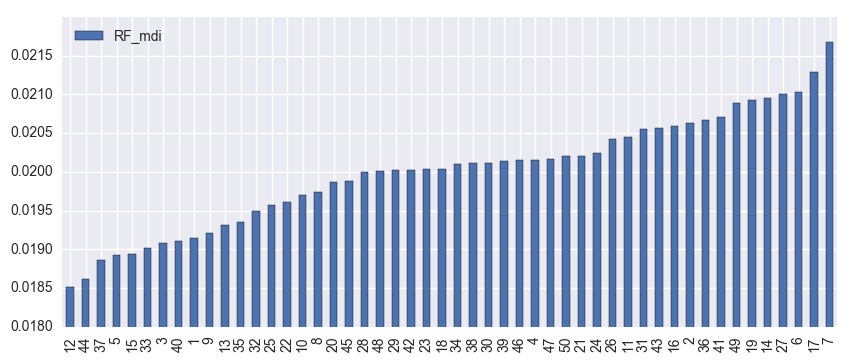

In [22]:
fig = plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
df_rf_mdi.sort('RF_mdi').plot(kind='bar',ax=ax)
ax.set_ylim([0.018,0.022])

#### Mean decrease accuracy

In [23]:
from sklearn.metrics import r2_score
from collections import defaultdict
from sklearn.cross_validation import ShuffleSplit

scores = defaultdict(list)

X = train.drop('target',axis=1).values
Y = train.target.values

m_rf = RF(n_jobs=6)

#crossvalidate the scores on a number of different random splits of the data
for train_idx, test_idx in ShuffleSplit(len(X), test_size=0.3):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    r = m_rf.fit(X_train, Y_train)
    acc = r2_score(Y_test, m_rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, m_rf.predict(X_t))
        scores[train.drop('target',axis=1).columns[i]].append((acc-shuff_acc)/acc)
print "Features sorted by their score:"
print sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True)

Features sorted by their score:
[(0.0023, 'feature40'), (0.0019, 'feature42'), (0.0017, 'feature18'), (0.0007, 'feature30'), (0.0005, 'feature45'), (0.0002, 'feature3'), (0.0002, 'feature27'), (0.0002, 'feature10'), (-0.0, 'feature34'), (-0.0001, 'feature31'), (-0.0005, 'feature36'), (-0.0008, 'feature38'), (-0.0008, 'feature19'), (-0.0008, 'feature11'), (-0.0009, 'feature28'), (-0.0009, 'feature14'), (-0.001, 'feature46'), (-0.001, 'feature4'), (-0.0011, 'feature7'), (-0.0012, 'feature43'), (-0.0012, 'feature2'), (-0.0013, 'feature47'), (-0.0014, 'feature33'), (-0.0015, 'feature50'), (-0.0015, 'feature25'), (-0.0015, 'feature23'), (-0.0018, 'feature17'), (-0.0019, 'feature9'), (-0.0022, 'feature35'), (-0.0022, 'feature15'), (-0.0024, 'feature49'), (-0.0024, 'feature44'), (-0.0025, 'feature37'), (-0.0026, 'feature41'), (-0.0026, 'feature32'), (-0.0026, 'feature1'), (-0.0027, 'feature29'), (-0.0029, 'feature13'), (-0.0032, 'feature22'), (-0.0033, 'feature5'), (-0.0033, 'feature16'), (-0

### Stability selection

In [24]:
x_train, x_test, y_train, y_test = train_test_split(train.drop('target', axis=1),
                                                    train.target,
                                                    test_size=0.2,
                                                    random_state=0)

In [25]:
from sklearn.linear_model import RandomizedLogisticRegression as RLR
warnings.filterwarnings('ignore')

m_rlr = RLR(C=0.5, n_resampling=50)
m_rlr.fit(x_train, y_train)

RandomizedLogisticRegression(C=0.5, fit_intercept=True,
               memory=Memory(cachedir=None), n_jobs=1, n_resampling=50,
               normalize=True, pre_dispatch='3*n_jobs', random_state=None,
               sample_fraction=0.75, scaling=0.5, selection_threshold=0.25,
               tol=0.001, verbose=False)

In [26]:
df_rlr = pd.DataFrame(m_rlr.scores_,index=range(1,len(train.columns)))
df_rlr.columns = ['RLR']

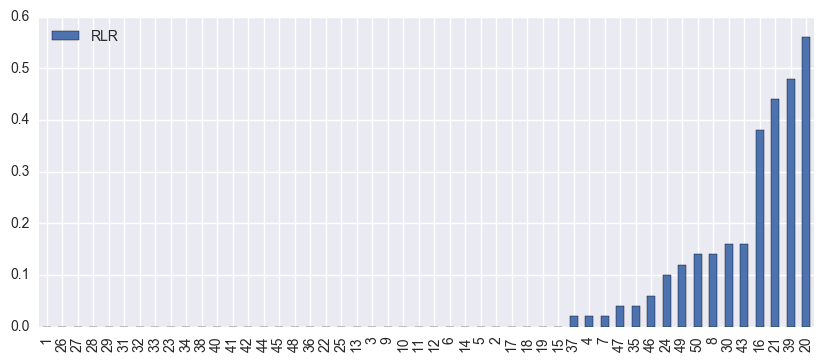

In [27]:
fig = plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
df_rlr.sort('RLR').plot(kind='bar',ax=ax)